In [1]:
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()


def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = np.array(
        [
            get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    ).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )

In [2]:
def feature_importance(model, data):
    f = {}
    fi = model.get_feature_importance()
    for i in range(len(fi)):
        f.update({data.columns[i]:fi[i]})
    
    return f

In [3]:
def to_list(tasks):
    user_ids = tasks.user_ids.values
    for i in range(len(tasks)):
        user_ids[i] = user_ids[i].split(',')
        user_ids[i] = [int(user_ids[i][j]) for j in range(len(user_ids[i]))]
    
    return user_ids

In [4]:
def user_ages_median(tasks):
    tasks.median_ages = tasks.user_ids.copy()
    for i in range(len(tasks)):
        for j in range(len(tasks.median_ages[i])):
            tasks.median_ages[i][j] = users.age.values[tasks.median_ages[i][j]]
    
    user_ages_median = [np.median(tasks.median_ages[i]) for i in range(len(tasks))]
    
    return user_ages_median

In [5]:
def n_views(tasks):
    pass

## Modules

In [6]:
import pandas as pd
import numpy as np
import json

## Пользователи

In [7]:
users = pd.read_csv('users.tsv', sep = '\t')
users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


## История

In [8]:
history = pd.read_csv('history.tsv', sep = '\t', index_col = 'user_id')
history.head()

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,hour,cpm,publisher
user_id,,,
15661,10,30.00,1
8444,8,41.26,1
15821,7,360.00,1
21530,18,370.00,1
22148,8,195.00,2


## Выборка

In [9]:
validate = pd.read_csv('validate.tsv',sep = '\t')
validate['delta_hour'] = validate['hour_end'] - validate['hour_start']
validate['cpm*hour'] = validate['cpm']*validate['delta_hour']

pub_count = [len(validate.publishers[i].split(',')) for i in range(len(validate))]
validate['cpm*pub'] = validate['cpm']*pd.Series(pub_count)

validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,delta_hour,cpm*hour,cpm*pub
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",95,20900.0,440.0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",6,1872.0,624.0
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",20,1400.0,420.0
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",82,19680.0,480.0
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",238,62356.0,1048.0


In [10]:
validate.user_ids = to_list(validate)
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,delta_hour,cpm*hour,cpm*pub
0,220.0,1058,1153,"7,17",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,20900.0,440.0
1,312.0,1295,1301,"3,18",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,1872.0,624.0
2,70.0,1229,1249,"1,2,3,9,15,21",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,1400.0,420.0
3,240.0,1295,1377,"1,14",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,19680.0,480.0
4,262.0,752,990,"1,3,7,8",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,62356.0,1048.0


In [11]:
median_ages = []
for i in range(len(validate)):
    median_ages.append(
        [users.age.values[validate.user_ids[i][j]] for j in range(len(validate.user_ids[i]))]
    )
validate['median_age'] = pd.Series([np.median(median_ages[i]) for i in range(len(validate))])
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,delta_hour,cpm*hour,cpm*pub,median_age
0,220.0,1058,1153,"7,17",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,20900.0,440.0,27.0
1,312.0,1295,1301,"3,18",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,1872.0,624.0,26.0
2,70.0,1229,1249,"1,2,3,9,15,21",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,1400.0,420.0,28.0
3,240.0,1295,1377,"1,14",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,19680.0,480.0,26.0
4,262.0,752,990,"1,3,7,8",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,62356.0,1048.0,44.0


In [97]:
with open('user_views.json', 'r') as file:
    user_views = json.loads(file.read())

In [99]:
n_views = []
for i in range(len(validate)):
    s = 0
    for j in range(len(validate.user_ids[i])):
        try:
            s += user_views[str(validate.user_ids[i][j])] + 1
        except KeyError:
                s += 1
    n_views.append(s/validate.audience_size[i])
    
validate['n_views'] = pd.Series(n_views)

In [12]:
user_pub = pd.read_csv('user_pub.csv')

In [100]:
publishers = validate.publishers.values
for i in range(len(validate)):
    publishers[i] = publishers[i].split(',')
validate

AttributeError: 'list' object has no attribute 'split'

In [72]:
n_views = []
for i in range(len(validate)):
    pub = validate.publishers[i]
    us = validate.user_ids[i]
    n_views.append(np.mean(user_pub.loc[us][pub].mean(axis = 1)))


In [74]:
n_views.count(0)

29

In [52]:
validate['n_views'] = pd.Series(n_views)
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,delta_hour,cpm*hour,cpm*pub,median_age,n_views,views_per_pub
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,20900.0,440.0,27.0,7.407135,1.851784
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,1872.0,624.0,26.0,26.076812,6.519203
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,1400.0,420.0,28.0,51.546171,1.431838
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,19680.0,480.0,26.0,4.381818,1.095455
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,62356.0,1048.0,44.0,51.130081,3.195630


In [101]:
validate['views_per_pub'] = validate['n_views']/pd.Series(pub_count)
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,delta_hour,cpm*hour,cpm*pub,median_age,n_views,views_per_pub
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",95,20900.0,440.0,27.0,41.567156,20.783578
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",6,1872.0,624.0,26.0,129.990580,64.995290
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",20,1400.0,420.0,28.0,44.977477,7.496246
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",82,19680.0,480.0,26.0,39.665909,19.832955
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",238,62356.0,1048.0,44.0,36.524390,9.131098


In [54]:
validate_answers = pd.read_csv('validate_answers.tsv', sep = '\t')
validate_answers.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


## Пользователи

In [95]:
# Распределение полов в users
sex = list(users.sex.values)
gender1 = sex.count(1)#14515
gender2 = sex.count(2)#13224
na = len(sex)-gender1-gender2#30
print(' gender1', gender1, '\n', 'gender2', gender2, '\n', 'na', na)

 gender1 14515 
 gender2 13224 
 na 30


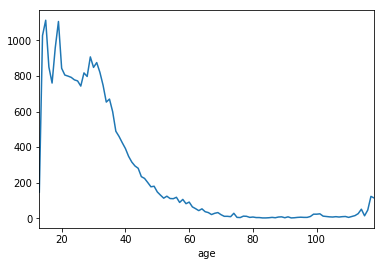

In [96]:
#Распределение возрастов в users
%matplotlib inline
users.groupby('age').count()['sex'].iloc[1:].plot()

In [97]:
false_age = (len(users[users.age>80])+len(users[users.age == 0]))
print('over 80 or no data:', false_age)

over 80 or no data: 2812


In [98]:
users.groupby('city_id').count()['sex']

city_id
0       8479
1         16
2          1
3       1985
4         66
        ... 
2452       1
2453       1
2454       1
2455       1
2456       1
Name: sex, Length: 2457, dtype: int64

## История просмотров

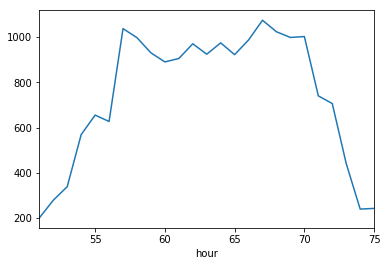

In [99]:
history.groupby('hour').count()['cpm'].loc[51:75].plot()

## Обучение

In [103]:
X = validate[['hour_start','audience_size','delta_hour','cpm*hour','cpm*pub', 'n_views','median_age','views_per_pub']]
y = validate_answers

In [104]:
X.head()

,hour_start,audience_size,delta_hour,cpm*hour,cpm*pub,n_views,median_age,views_per_pub
0,1058,1906,95,20900.0,440.0,41.567156,27.0,20.783578
1,1295,1380,6,1872.0,624.0,129.990580,26.0,64.995290
2,1229,888,20,1400.0,420.0,44.977477,28.0,7.496246
3,1295,440,82,19680.0,480.0,39.665909,26.0,19.832955
4,752,1476,238,62356.0,1048.0,36.524390,44.0,9.131098


In [106]:
from catboost import CatBoostRegressor, Pool
clf = CatBoostRegressor(loss_function = 'MultiRMSE')

In [107]:
#X['n_views'] = pd.Series(n_views)+0.001
X['p_win'] = 1-(1-y['at_least_one'])**(1/X['n_views'])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
p_win_reg = CatBoostRegressor()
p_win_reg.fit(X_train[['hour_start', 'audience_size', 'delta_hour', 'cpm*hour', 'cpm*pub',
       'n_views','median_age','views_per_pub']],X_train['p_win'])

0:	learn: 0.0045999	total: 219ms	remaining: 3m 38s
1:	learn: 0.0045425	total: 227ms	remaining: 1m 53s
2:	learn: 0.0044868	total: 238ms	remaining: 1m 18s
3:	learn: 0.0044312	total: 248ms	remaining: 1m 1s
4:	learn: 0.0043802	total: 260ms	remaining: 51.7s
5:	learn: 0.0043301	total: 271ms	remaining: 44.9s
6:	learn: 0.0042821	total: 292ms	remaining: 41.4s
7:	learn: 0.0042349	total: 302ms	remaining: 37.4s
8:	learn: 0.0041936	total: 309ms	remaining: 34s
9:	learn: 0.0041462	total: 315ms	remaining: 31.2s
10:	learn: 0.0041032	total: 322ms	remaining: 28.9s
11:	learn: 0.0040630	total: 335ms	remaining: 27.6s
12:	learn: 0.0040286	total: 356ms	remaining: 27s
13:	learn: 0.0039904	total: 369ms	remaining: 26s
14:	learn: 0.0039502	total: 374ms	remaining: 24.6s
15:	learn: 0.0039121	total: 383ms	remaining: 23.5s
16:	learn: 0.0038781	total: 389ms	remaining: 22.5s
17:	learn: 0.0038450	total: 396ms	remaining: 21.6s
18:	learn: 0.0038126	total: 419ms	remaining: 21.6s
19:	learn: 0.0037799	total: 427ms	remaining:

167:	learn: 0.0023532	total: 1.6s	remaining: 7.95s
168:	learn: 0.0023489	total: 1.62s	remaining: 7.97s
169:	learn: 0.0023449	total: 1.63s	remaining: 7.95s
170:	learn: 0.0023388	total: 1.64s	remaining: 7.94s
171:	learn: 0.0023363	total: 1.65s	remaining: 7.92s
172:	learn: 0.0023335	total: 1.65s	remaining: 7.91s
173:	learn: 0.0023311	total: 1.66s	remaining: 7.89s
174:	learn: 0.0023245	total: 1.67s	remaining: 7.87s
175:	learn: 0.0023228	total: 1.68s	remaining: 7.87s
176:	learn: 0.0023197	total: 1.69s	remaining: 7.86s
177:	learn: 0.0023153	total: 1.7s	remaining: 7.86s
178:	learn: 0.0023139	total: 1.71s	remaining: 7.84s
179:	learn: 0.0023100	total: 1.72s	remaining: 7.82s
180:	learn: 0.0023041	total: 1.72s	remaining: 7.8s
181:	learn: 0.0023002	total: 1.74s	remaining: 7.8s
182:	learn: 0.0022955	total: 1.75s	remaining: 7.8s
183:	learn: 0.0022912	total: 1.75s	remaining: 7.77s
184:	learn: 0.0022872	total: 1.76s	remaining: 7.75s
185:	learn: 0.0022835	total: 1.76s	remaining: 7.73s
186:	learn: 0.002

334:	learn: 0.0018882	total: 2.76s	remaining: 5.48s
335:	learn: 0.0018845	total: 2.77s	remaining: 5.47s
336:	learn: 0.0018823	total: 2.78s	remaining: 5.47s
337:	learn: 0.0018805	total: 2.79s	remaining: 5.46s
338:	learn: 0.0018772	total: 2.79s	remaining: 5.44s
339:	learn: 0.0018759	total: 2.8s	remaining: 5.43s
340:	learn: 0.0018726	total: 2.81s	remaining: 5.42s
341:	learn: 0.0018702	total: 2.81s	remaining: 5.42s
342:	learn: 0.0018689	total: 2.82s	remaining: 5.41s
343:	learn: 0.0018655	total: 2.83s	remaining: 5.39s
344:	learn: 0.0018636	total: 2.83s	remaining: 5.38s
345:	learn: 0.0018626	total: 2.84s	remaining: 5.37s
346:	learn: 0.0018620	total: 2.84s	remaining: 5.35s
347:	learn: 0.0018601	total: 2.85s	remaining: 5.34s
348:	learn: 0.0018589	total: 2.85s	remaining: 5.32s
349:	learn: 0.0018575	total: 2.86s	remaining: 5.31s
350:	learn: 0.0018559	total: 2.86s	remaining: 5.3s
351:	learn: 0.0018546	total: 2.87s	remaining: 5.28s
352:	learn: 0.0018508	total: 2.88s	remaining: 5.27s
353:	learn: 0.

501:	learn: 0.0015497	total: 3.71s	remaining: 3.68s
502:	learn: 0.0015466	total: 3.72s	remaining: 3.68s
503:	learn: 0.0015449	total: 3.73s	remaining: 3.67s
504:	learn: 0.0015430	total: 3.74s	remaining: 3.67s
505:	learn: 0.0015408	total: 3.75s	remaining: 3.66s
506:	learn: 0.0015392	total: 3.75s	remaining: 3.65s
507:	learn: 0.0015382	total: 3.76s	remaining: 3.64s
508:	learn: 0.0015366	total: 3.77s	remaining: 3.63s
509:	learn: 0.0015345	total: 3.77s	remaining: 3.62s
510:	learn: 0.0015316	total: 3.77s	remaining: 3.61s
511:	learn: 0.0015296	total: 3.78s	remaining: 3.6s
512:	learn: 0.0015285	total: 3.79s	remaining: 3.59s
513:	learn: 0.0015271	total: 3.79s	remaining: 3.58s
514:	learn: 0.0015244	total: 3.8s	remaining: 3.58s
515:	learn: 0.0015222	total: 3.8s	remaining: 3.57s
516:	learn: 0.0015196	total: 3.81s	remaining: 3.56s
517:	learn: 0.0015175	total: 3.81s	remaining: 3.55s
518:	learn: 0.0015164	total: 3.82s	remaining: 3.54s
519:	learn: 0.0015146	total: 3.82s	remaining: 3.53s
520:	learn: 0.0

675:	learn: 0.0012709	total: 4.68s	remaining: 2.24s
676:	learn: 0.0012697	total: 4.68s	remaining: 2.23s
677:	learn: 0.0012677	total: 4.69s	remaining: 2.23s
678:	learn: 0.0012660	total: 4.69s	remaining: 2.22s
679:	learn: 0.0012647	total: 4.7s	remaining: 2.21s
680:	learn: 0.0012620	total: 4.71s	remaining: 2.2s
681:	learn: 0.0012608	total: 4.72s	remaining: 2.2s
682:	learn: 0.0012594	total: 4.72s	remaining: 2.19s
683:	learn: 0.0012580	total: 4.73s	remaining: 2.18s
684:	learn: 0.0012559	total: 4.73s	remaining: 2.18s
685:	learn: 0.0012539	total: 4.74s	remaining: 2.17s
686:	learn: 0.0012524	total: 4.74s	remaining: 2.16s
687:	learn: 0.0012507	total: 4.75s	remaining: 2.15s
688:	learn: 0.0012502	total: 4.75s	remaining: 2.15s
689:	learn: 0.0012481	total: 4.76s	remaining: 2.14s
690:	learn: 0.0012463	total: 4.76s	remaining: 2.13s
691:	learn: 0.0012461	total: 4.77s	remaining: 2.12s
692:	learn: 0.0012441	total: 4.77s	remaining: 2.11s
693:	learn: 0.0012433	total: 4.78s	remaining: 2.11s
694:	learn: 0.0

851:	learn: 0.0010635	total: 5.63s	remaining: 978ms
852:	learn: 0.0010632	total: 5.64s	remaining: 972ms
853:	learn: 0.0010629	total: 5.64s	remaining: 965ms
854:	learn: 0.0010612	total: 5.65s	remaining: 958ms
855:	learn: 0.0010607	total: 5.65s	remaining: 951ms
856:	learn: 0.0010594	total: 5.66s	remaining: 945ms
857:	learn: 0.0010583	total: 5.67s	remaining: 938ms
858:	learn: 0.0010570	total: 5.67s	remaining: 932ms
859:	learn: 0.0010559	total: 5.68s	remaining: 925ms
860:	learn: 0.0010551	total: 5.68s	remaining: 918ms
861:	learn: 0.0010546	total: 5.69s	remaining: 911ms
862:	learn: 0.0010528	total: 5.7s	remaining: 904ms
863:	learn: 0.0010521	total: 5.7s	remaining: 898ms
864:	learn: 0.0010509	total: 5.71s	remaining: 891ms
865:	learn: 0.0010508	total: 5.71s	remaining: 884ms
866:	learn: 0.0010497	total: 5.72s	remaining: 877ms
867:	learn: 0.0010484	total: 5.72s	remaining: 870ms
868:	learn: 0.0010468	total: 5.73s	remaining: 863ms
869:	learn: 0.0010456	total: 5.73s	remaining: 857ms
870:	learn: 0.

In [112]:
feature_importance(p_win_reg, X_train[['hour_start', 'audience_size', 'delta_hour', 'cpm*hour', 'cpm*pub','n_views','median_age','views_per_pub']])

{'hour_start': 7.280810942728856,
 'audience_size': 6.712284994860803,
 'delta_hour': 16.41475254534145,
 'cpm*hour': 26.464642251558764,
 'cpm*pub': 11.731403164875303,
 'n_views': 8.571611024854802,
 'median_age': 7.65904882689374,
 'views_per_pub': 15.165446248886282}

In [81]:
p_win_reg.save_model('pwin.cbm','cbm')

In [126]:
X['1-p_reach'] = (1-X['p_win'])**(X['n_views'])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = True)

In [122]:
clf.fit(X_train,y_train)

0:	learn: 0.2550383	total: 13.3ms	remaining: 13.2s
1:	learn: 0.2501843	total: 24.7ms	remaining: 12.3s
2:	learn: 0.2447512	total: 36ms	remaining: 12s
3:	learn: 0.2395729	total: 48ms	remaining: 12s
4:	learn: 0.2352219	total: 59.4ms	remaining: 11.8s
5:	learn: 0.2303112	total: 71.9ms	remaining: 11.9s
6:	learn: 0.2264936	total: 84.9ms	remaining: 12s
7:	learn: 0.2217051	total: 97.2ms	remaining: 12.1s
8:	learn: 0.2174814	total: 109ms	remaining: 11.9s
9:	learn: 0.2133093	total: 122ms	remaining: 12.1s
10:	learn: 0.2087980	total: 135ms	remaining: 12.1s
11:	learn: 0.2046500	total: 147ms	remaining: 12.1s
12:	learn: 0.2006179	total: 159ms	remaining: 12.1s
13:	learn: 0.1967247	total: 172ms	remaining: 12.1s
14:	learn: 0.1925405	total: 184ms	remaining: 12.1s
15:	learn: 0.1885281	total: 198ms	remaining: 12.2s
16:	learn: 0.1847635	total: 214ms	remaining: 12.4s
17:	learn: 0.1814631	total: 231ms	remaining: 12.6s
18:	learn: 0.1781854	total: 246ms	remaining: 12.7s
19:	learn: 0.1749063	total: 261ms	remaining

169:	learn: 0.0306309	total: 2.27s	remaining: 11.1s
170:	learn: 0.0303923	total: 2.29s	remaining: 11.1s
171:	learn: 0.0302488	total: 2.3s	remaining: 11.1s
172:	learn: 0.0300327	total: 2.32s	remaining: 11.1s
173:	learn: 0.0298441	total: 2.33s	remaining: 11.1s
174:	learn: 0.0296619	total: 2.34s	remaining: 11s
175:	learn: 0.0295151	total: 2.35s	remaining: 11s
176:	learn: 0.0292582	total: 2.37s	remaining: 11s
177:	learn: 0.0291020	total: 2.38s	remaining: 11s
178:	learn: 0.0289891	total: 2.39s	remaining: 11s
179:	learn: 0.0288469	total: 2.4s	remaining: 10.9s
180:	learn: 0.0286835	total: 2.41s	remaining: 10.9s
181:	learn: 0.0284729	total: 2.42s	remaining: 10.9s
182:	learn: 0.0282974	total: 2.43s	remaining: 10.9s
183:	learn: 0.0281448	total: 2.44s	remaining: 10.8s
184:	learn: 0.0280840	total: 2.46s	remaining: 10.8s
185:	learn: 0.0279593	total: 2.47s	remaining: 10.8s
186:	learn: 0.0278820	total: 2.49s	remaining: 10.8s
187:	learn: 0.0277360	total: 2.5s	remaining: 10.8s
188:	learn: 0.0275782	tot

334:	learn: 0.0167406	total: 4.29s	remaining: 8.53s
335:	learn: 0.0166843	total: 4.31s	remaining: 8.51s
336:	learn: 0.0166438	total: 4.32s	remaining: 8.5s
337:	learn: 0.0165968	total: 4.34s	remaining: 8.49s
338:	learn: 0.0165516	total: 4.35s	remaining: 8.48s
339:	learn: 0.0165048	total: 4.36s	remaining: 8.47s
340:	learn: 0.0164747	total: 4.37s	remaining: 8.45s
341:	learn: 0.0164255	total: 4.38s	remaining: 8.44s
342:	learn: 0.0163679	total: 4.4s	remaining: 8.42s
343:	learn: 0.0163506	total: 4.41s	remaining: 8.4s
344:	learn: 0.0163044	total: 4.42s	remaining: 8.39s
345:	learn: 0.0162875	total: 4.43s	remaining: 8.37s
346:	learn: 0.0162560	total: 4.44s	remaining: 8.36s
347:	learn: 0.0162258	total: 4.45s	remaining: 8.34s
348:	learn: 0.0161599	total: 4.46s	remaining: 8.32s
349:	learn: 0.0161082	total: 4.47s	remaining: 8.31s
350:	learn: 0.0160663	total: 4.48s	remaining: 8.29s
351:	learn: 0.0160421	total: 4.5s	remaining: 8.28s
352:	learn: 0.0160010	total: 4.51s	remaining: 8.27s
353:	learn: 0.01

498:	learn: 0.0120239	total: 6.32s	remaining: 6.35s
499:	learn: 0.0120075	total: 6.33s	remaining: 6.33s
500:	learn: 0.0119876	total: 6.35s	remaining: 6.32s
501:	learn: 0.0119624	total: 6.36s	remaining: 6.31s
502:	learn: 0.0119416	total: 6.38s	remaining: 6.3s
503:	learn: 0.0119121	total: 6.39s	remaining: 6.29s
504:	learn: 0.0118880	total: 6.4s	remaining: 6.28s
505:	learn: 0.0118710	total: 6.42s	remaining: 6.26s
506:	learn: 0.0118435	total: 6.43s	remaining: 6.25s
507:	learn: 0.0118131	total: 6.44s	remaining: 6.24s
508:	learn: 0.0117968	total: 6.45s	remaining: 6.22s
509:	learn: 0.0117772	total: 6.46s	remaining: 6.21s
510:	learn: 0.0117570	total: 6.47s	remaining: 6.19s
511:	learn: 0.0117455	total: 6.48s	remaining: 6.18s
512:	learn: 0.0117270	total: 6.5s	remaining: 6.17s
513:	learn: 0.0117089	total: 6.51s	remaining: 6.15s
514:	learn: 0.0116850	total: 6.52s	remaining: 6.14s
515:	learn: 0.0116716	total: 6.54s	remaining: 6.13s
516:	learn: 0.0116555	total: 6.55s	remaining: 6.12s
517:	learn: 0.0

665:	learn: 0.0092490	total: 8.8s	remaining: 4.41s
666:	learn: 0.0092401	total: 8.81s	remaining: 4.4s
667:	learn: 0.0092302	total: 8.83s	remaining: 4.39s
668:	learn: 0.0092155	total: 8.84s	remaining: 4.38s
669:	learn: 0.0092051	total: 8.86s	remaining: 4.36s
670:	learn: 0.0091840	total: 8.87s	remaining: 4.35s
671:	learn: 0.0091678	total: 8.88s	remaining: 4.33s
672:	learn: 0.0091570	total: 8.89s	remaining: 4.32s
673:	learn: 0.0091483	total: 8.91s	remaining: 4.31s
674:	learn: 0.0091346	total: 8.92s	remaining: 4.29s
675:	learn: 0.0091223	total: 8.93s	remaining: 4.28s
676:	learn: 0.0091087	total: 8.94s	remaining: 4.26s
677:	learn: 0.0090996	total: 8.95s	remaining: 4.25s
678:	learn: 0.0090926	total: 8.96s	remaining: 4.24s
679:	learn: 0.0090688	total: 8.97s	remaining: 4.22s
680:	learn: 0.0090523	total: 8.98s	remaining: 4.21s
681:	learn: 0.0090367	total: 8.99s	remaining: 4.19s
682:	learn: 0.0090266	total: 9.01s	remaining: 4.18s
683:	learn: 0.0090175	total: 9.02s	remaining: 4.17s
684:	learn: 0.

832:	learn: 0.0073623	total: 10.9s	remaining: 2.18s
833:	learn: 0.0073499	total: 10.9s	remaining: 2.17s
834:	learn: 0.0073431	total: 10.9s	remaining: 2.15s
835:	learn: 0.0073390	total: 10.9s	remaining: 2.14s
836:	learn: 0.0073290	total: 10.9s	remaining: 2.13s
837:	learn: 0.0073191	total: 10.9s	remaining: 2.11s
838:	learn: 0.0073059	total: 11s	remaining: 2.1s
839:	learn: 0.0073003	total: 11s	remaining: 2.09s
840:	learn: 0.0072943	total: 11s	remaining: 2.07s
841:	learn: 0.0072859	total: 11s	remaining: 2.06s
842:	learn: 0.0072819	total: 11s	remaining: 2.05s
843:	learn: 0.0072762	total: 11s	remaining: 2.03s
844:	learn: 0.0072702	total: 11s	remaining: 2.02s
845:	learn: 0.0072659	total: 11s	remaining: 2.01s
846:	learn: 0.0072564	total: 11s	remaining: 1.99s
847:	learn: 0.0072466	total: 11.1s	remaining: 1.98s
848:	learn: 0.0072384	total: 11.1s	remaining: 1.97s
849:	learn: 0.0072337	total: 11.1s	remaining: 1.96s
850:	learn: 0.0072260	total: 11.1s	remaining: 1.94s
851:	learn: 0.0072159	total: 11

991:	learn: 0.0061174	total: 12.9s	remaining: 104ms
992:	learn: 0.0061111	total: 12.9s	remaining: 90.8ms
993:	learn: 0.0061075	total: 12.9s	remaining: 77.8ms
994:	learn: 0.0061038	total: 12.9s	remaining: 64.8ms
995:	learn: 0.0061010	total: 12.9s	remaining: 51.9ms
996:	learn: 0.0060937	total: 12.9s	remaining: 38.9ms
997:	learn: 0.0060892	total: 12.9s	remaining: 25.9ms
998:	learn: 0.0060793	total: 13s	remaining: 13ms
999:	learn: 0.0060719	total: 13s	remaining: 0us


In [123]:
X_test = X_test.reset_index()
y_test = y_test.reset_index()

In [124]:
get_smoothed_mean_log_accuracy_ratio(pd.DataFrame(clf.predict(X_test[X_test.columns[1:]]),columns = ['at_least_one',
                                                                                'at_least_two',
                                                                                'at_least_three']),
                                     y_test[y_test.columns[1:]], epsilon=0.005)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


20.6

In [83]:
feature_importance(clf,X)

{'hour_start': 1.6263727042996177,
 'audience_size': 1.7371082181227682,
 'delta_hour': 7.465370738674307,
 'cpm*hour': 10.188616368229884,
 'cpm*pub': 2.9082308874413827,
 'n_views': 17.52760254176318,
 'median_age': 1.356265927823502,
 'p_win': 57.190432613645356}

In [84]:
clf.save_model('model.cbm', 'cbm')

In [57]:
X

,hour_start,audience_size,delta_hour,cpm*hour,cpm*pub,n_views,views_per_pub,median_age,p_win,1-p_reach
0,1058,1906,95,20900.0,440.0,3.704568,1.851784,27.0,0.011794,0.996803
1,1295,1380,6,1872.0,624.0,13.039406,6.519203,26.0,0.001003,0.999923
2,1229,888,20,1400.0,420.0,8.592029,1.431838,28.0,0.010639,0.998756
3,1295,440,82,19680.0,480.0,2.191909,1.095455,26.0,0.112143,0.947181
4,752,1476,238,62356.0,1048.0,12.783520,3.195630,44.0,0.038710,0.996917
...,...,...,...,...,...,...,...,...,...,...
1003,1095,368,59,7493.0,635.0,6.388500,1.277500,27.0,0.010946,0.998279
1004,1052,484,4,360.0,180.0,11.170421,5.584711,26.0,0.001488,0.999867
1005,1058,704,5,610.0,244.0,11.213358,5.606179,25.0,0.000635,0.999943
1006,932,1210,237,32706.0,414.0,10.857749,3.618916,88.0,0.041227,0.996130


In [189]:
user_pub = pd.DataFrame(data = np.zeros((len(users),21)), columns = np.arange(1,22,1))
user_pub

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
for k in range(len(validate)):
    for i in validate.user_ids[k]:
        for j in validate.publishers[k]:
            try:
                user_pub.values[i][j] += 1
            except IndexError:
                k+=1

In [191]:
user_pub

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.0,28.0,31.0,26.0,4.0,8.0,8.0,28.0,3.0,3.0,...,6.0,5.0,8.0,5.0,4.0,3.0,5.0,2.0,2.0,4.0
1,0.0,23.0,20.0,23.0,5.0,5.0,4.0,23.0,3.0,7.0,...,3.0,2.0,2.0,3.0,3.0,3.0,4.0,7.0,6.0,5.0
2,0.0,27.0,41.0,33.0,9.0,5.0,8.0,32.0,8.0,3.0,...,8.0,2.0,9.0,5.0,3.0,3.0,5.0,3.0,6.0,6.0
3,0.0,22.0,28.0,22.0,3.0,4.0,5.0,24.0,5.0,6.0,...,8.0,0.0,1.0,6.0,4.0,3.0,4.0,6.0,5.0,7.0
4,0.0,26.0,30.0,31.0,6.0,8.0,5.0,33.0,7.0,6.0,...,6.0,2.0,7.0,4.0,5.0,5.0,6.0,5.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27764,0.0,6.0,10.0,6.0,0.0,1.0,2.0,6.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,3.0,0.0,3.0,3.0,1.0
27765,0.0,9.0,11.0,10.0,0.0,0.0,2.0,9.0,1.0,3.0,...,2.0,1.0,2.0,3.0,0.0,3.0,2.0,3.0,2.0,2.0
27766,0.0,16.0,14.0,19.0,4.0,5.0,4.0,19.0,1.0,3.0,...,8.0,4.0,0.0,2.0,2.0,2.0,3.0,4.0,4.0,3.0
27767,0.0,14.0,23.0,13.0,4.0,2.0,0.0,16.0,3.0,1.0,...,2.0,3.0,4.0,0.0,3.0,2.0,4.0,5.0,6.0,3.0


In [206]:
user_pub.to_csv('user_pub.csv', header = True, index = False)

In [30]:
pd.read_csv('user_pub.csv')

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.0,28.0,31.0,26.0,4.0,8.0,8.0,28.0,3.0,3.0,...,6.0,5.0,8.0,5.0,4.0,3.0,5.0,2.0,2.0,4.0
1,0.0,23.0,20.0,23.0,5.0,5.0,4.0,23.0,3.0,7.0,...,3.0,2.0,2.0,3.0,3.0,3.0,4.0,7.0,6.0,5.0
2,0.0,27.0,41.0,33.0,9.0,5.0,8.0,32.0,8.0,3.0,...,8.0,2.0,9.0,5.0,3.0,3.0,5.0,3.0,6.0,6.0
3,0.0,22.0,28.0,22.0,3.0,4.0,5.0,24.0,5.0,6.0,...,8.0,0.0,1.0,6.0,4.0,3.0,4.0,6.0,5.0,7.0
4,0.0,26.0,30.0,31.0,6.0,8.0,5.0,33.0,7.0,6.0,...,6.0,2.0,7.0,4.0,5.0,5.0,6.0,5.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27764,0.0,6.0,10.0,6.0,0.0,1.0,2.0,6.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,3.0,0.0,3.0,3.0,1.0
27765,0.0,9.0,11.0,10.0,0.0,0.0,2.0,9.0,1.0,3.0,...,2.0,1.0,2.0,3.0,0.0,3.0,2.0,3.0,2.0,2.0
27766,0.0,16.0,14.0,19.0,4.0,5.0,4.0,19.0,1.0,3.0,...,8.0,4.0,0.0,2.0,2.0,2.0,3.0,4.0,4.0,3.0
27767,0.0,14.0,23.0,13.0,4.0,2.0,0.0,16.0,3.0,1.0,...,2.0,3.0,4.0,0.0,3.0,2.0,4.0,5.0,6.0,3.0


In [127]:
X

,hour_start,audience_size,delta_hour,cpm*hour,cpm*pub,n_views,median_age,views_per_pub,p_win,1-p_reach
0,1058,1906,95,20900.0,440.0,41.567156,27.0,20.783578,0.001057,0.9570
1,1295,1380,6,1872.0,624.0,129.990580,26.0,64.995290,0.000101,0.9870
2,1229,888,20,1400.0,420.0,44.977477,28.0,7.496246,0.002041,0.9122
3,1295,440,82,19680.0,480.0,39.665909,26.0,19.832955,0.006551,0.7705
4,752,1476,238,62356.0,1048.0,36.524390,44.0,9.131098,0.013723,0.6037
...,...,...,...,...,...,...,...,...,...,...
1003,1095,368,59,7493.0,635.0,38.201087,27.0,7.640217,0.001839,0.9321
1004,1052,484,4,360.0,180.0,42.793388,26.0,21.396694,0.000389,0.9835
1005,1058,704,5,610.0,244.0,116.884943,25.0,58.442472,0.000061,0.9929
1006,932,1210,237,32706.0,414.0,36.154545,88.0,12.051515,0.012564,0.6331


In [128]:
X['p_win'] = 1-(1-y['at_least_one'])**(1/X['n_views'])
p_win_reg.fit(X[['hour_start', 'audience_size', 'delta_hour', 'cpm*hour', 'cpm*pub',
       'n_views','median_age','views_per_pub']],X['p_win'])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0:	learn: 0.0045184	total: 363ms	remaining: 6m 2s
1:	learn: 0.0044571	total: 411ms	remaining: 3m 25s
2:	learn: 0.0044015	total: 417ms	remaining: 2m 18s
3:	learn: 0.0043493	total: 424ms	remaining: 1m 45s
4:	learn: 0.0042958	total: 450ms	remaining: 1m 29s
5:	learn: 0.0042453	total: 456ms	remaining: 1m 15s
6:	learn: 0.0041973	total: 474ms	remaining: 1m 7s
7:	learn: 0.0041523	total: 481ms	remaining: 59.7s
8:	learn: 0.0041076	total: 488ms	remaining: 53.7s
9:	learn: 0.0040647	total: 494ms	remaining: 48.9s
10:	learn: 0.0040213	total: 517ms	remaining: 46.5s
11:	learn: 0.0039810	total: 567ms	remaining: 46.6s
12:	learn: 0.0039439	total: 591ms	remaining: 44.9s
13:	learn: 0.0039067	total: 612ms	remaining: 43.1s
14:	learn: 0.0038680	total: 672ms	remaining: 44.1s
15:	learn: 0.0038347	total: 683ms	remaining: 42s
16:	learn: 0.0038035	total: 703ms	remaining: 40.7s
17:	learn: 0.0037698	total: 726ms	remaining: 39.6s
18:	learn: 0.0037380	total: 733ms	remaining: 37.8s
19:	learn: 0.0037062	total: 737ms	rema

171:	learn: 0.0024021	total: 2.41s	remaining: 11.6s
172:	learn: 0.0024013	total: 2.46s	remaining: 11.8s
173:	learn: 0.0023960	total: 2.47s	remaining: 11.7s
174:	learn: 0.0023942	total: 2.48s	remaining: 11.7s
175:	learn: 0.0023912	total: 2.49s	remaining: 11.6s
176:	learn: 0.0023876	total: 2.5s	remaining: 11.6s
177:	learn: 0.0023851	total: 2.5s	remaining: 11.6s
178:	learn: 0.0023815	total: 2.51s	remaining: 11.5s
179:	learn: 0.0023794	total: 2.52s	remaining: 11.5s
180:	learn: 0.0023777	total: 2.52s	remaining: 11.4s
181:	learn: 0.0023739	total: 2.53s	remaining: 11.4s
182:	learn: 0.0023708	total: 2.54s	remaining: 11.4s
183:	learn: 0.0023671	total: 2.55s	remaining: 11.3s
184:	learn: 0.0023643	total: 2.57s	remaining: 11.3s
185:	learn: 0.0023629	total: 2.58s	remaining: 11.3s
186:	learn: 0.0023591	total: 2.58s	remaining: 11.2s
187:	learn: 0.0023566	total: 2.59s	remaining: 11.2s
188:	learn: 0.0023521	total: 2.6s	remaining: 11.1s
189:	learn: 0.0023485	total: 2.61s	remaining: 11.1s
190:	learn: 0.0

346:	learn: 0.0019797	total: 4.21s	remaining: 7.93s
347:	learn: 0.0019767	total: 4.23s	remaining: 7.92s
348:	learn: 0.0019757	total: 4.23s	remaining: 7.9s
349:	learn: 0.0019752	total: 4.24s	remaining: 7.87s
350:	learn: 0.0019737	total: 4.25s	remaining: 7.85s
351:	learn: 0.0019699	total: 4.25s	remaining: 7.83s
352:	learn: 0.0019681	total: 4.26s	remaining: 7.81s
353:	learn: 0.0019665	total: 4.27s	remaining: 7.79s
354:	learn: 0.0019632	total: 4.27s	remaining: 7.77s
355:	learn: 0.0019627	total: 4.28s	remaining: 7.74s
356:	learn: 0.0019597	total: 4.29s	remaining: 7.72s
357:	learn: 0.0019580	total: 4.29s	remaining: 7.7s
358:	learn: 0.0019544	total: 4.3s	remaining: 7.68s
359:	learn: 0.0019518	total: 4.3s	remaining: 7.65s
360:	learn: 0.0019492	total: 4.31s	remaining: 7.63s
361:	learn: 0.0019469	total: 4.32s	remaining: 7.61s
362:	learn: 0.0019444	total: 4.33s	remaining: 7.59s
363:	learn: 0.0019435	total: 4.33s	remaining: 7.57s
364:	learn: 0.0019422	total: 4.33s	remaining: 7.54s
365:	learn: 0.00

512:	learn: 0.0016738	total: 5.56s	remaining: 5.28s
513:	learn: 0.0016733	total: 5.57s	remaining: 5.26s
514:	learn: 0.0016720	total: 5.57s	remaining: 5.25s
515:	learn: 0.0016711	total: 5.58s	remaining: 5.23s
516:	learn: 0.0016687	total: 5.58s	remaining: 5.21s
517:	learn: 0.0016665	total: 5.59s	remaining: 5.2s
518:	learn: 0.0016634	total: 5.59s	remaining: 5.18s
519:	learn: 0.0016609	total: 5.6s	remaining: 5.17s
520:	learn: 0.0016587	total: 5.61s	remaining: 5.16s
521:	learn: 0.0016579	total: 5.62s	remaining: 5.15s
522:	learn: 0.0016575	total: 5.63s	remaining: 5.13s
523:	learn: 0.0016554	total: 5.64s	remaining: 5.12s
524:	learn: 0.0016549	total: 5.64s	remaining: 5.11s
525:	learn: 0.0016538	total: 5.65s	remaining: 5.09s
526:	learn: 0.0016510	total: 5.67s	remaining: 5.09s
527:	learn: 0.0016495	total: 5.68s	remaining: 5.08s
528:	learn: 0.0016480	total: 5.69s	remaining: 5.06s
529:	learn: 0.0016477	total: 5.69s	remaining: 5.05s
530:	learn: 0.0016472	total: 5.72s	remaining: 5.05s
531:	learn: 0.

672:	learn: 0.0014474	total: 6.96s	remaining: 3.38s
673:	learn: 0.0014460	total: 6.97s	remaining: 3.37s
674:	learn: 0.0014459	total: 6.98s	remaining: 3.36s
675:	learn: 0.0014431	total: 6.98s	remaining: 3.35s
676:	learn: 0.0014411	total: 6.99s	remaining: 3.33s
677:	learn: 0.0014403	total: 7s	remaining: 3.32s
678:	learn: 0.0014396	total: 7.01s	remaining: 3.31s
679:	learn: 0.0014385	total: 7.01s	remaining: 3.3s
680:	learn: 0.0014369	total: 7.02s	remaining: 3.29s
681:	learn: 0.0014362	total: 7.03s	remaining: 3.28s
682:	learn: 0.0014349	total: 7.04s	remaining: 3.27s
683:	learn: 0.0014348	total: 7.05s	remaining: 3.26s
684:	learn: 0.0014342	total: 7.06s	remaining: 3.25s
685:	learn: 0.0014336	total: 7.06s	remaining: 3.23s
686:	learn: 0.0014329	total: 7.07s	remaining: 3.22s
687:	learn: 0.0014318	total: 7.07s	remaining: 3.21s
688:	learn: 0.0014306	total: 7.08s	remaining: 3.19s
689:	learn: 0.0014283	total: 7.08s	remaining: 3.18s
690:	learn: 0.0014275	total: 7.09s	remaining: 3.17s
691:	learn: 0.00

834:	learn: 0.0012452	total: 8.13s	remaining: 1.61s
835:	learn: 0.0012444	total: 8.14s	remaining: 1.6s
836:	learn: 0.0012433	total: 8.15s	remaining: 1.59s
837:	learn: 0.0012429	total: 8.15s	remaining: 1.58s
838:	learn: 0.0012427	total: 8.16s	remaining: 1.57s
839:	learn: 0.0012418	total: 8.17s	remaining: 1.56s
840:	learn: 0.0012404	total: 8.18s	remaining: 1.55s
841:	learn: 0.0012397	total: 8.18s	remaining: 1.53s
842:	learn: 0.0012386	total: 8.19s	remaining: 1.52s
843:	learn: 0.0012378	total: 8.2s	remaining: 1.51s
844:	learn: 0.0012367	total: 8.2s	remaining: 1.5s
845:	learn: 0.0012363	total: 8.21s	remaining: 1.49s
846:	learn: 0.0012352	total: 8.21s	remaining: 1.48s
847:	learn: 0.0012338	total: 8.22s	remaining: 1.47s
848:	learn: 0.0012327	total: 8.22s	remaining: 1.46s
849:	learn: 0.0012317	total: 8.23s	remaining: 1.45s
850:	learn: 0.0012308	total: 8.23s	remaining: 1.44s
851:	learn: 0.0012302	total: 8.24s	remaining: 1.43s
852:	learn: 0.0012299	total: 8.24s	remaining: 1.42s
853:	learn: 0.00

In [129]:
p_win_reg.save_model('pwin.cbm','cbm')

In [130]:
clf.fit(X,y)

0:	learn: 0.2482710	total: 1.65s	remaining: 27m 27s
1:	learn: 0.2427668	total: 1.67s	remaining: 13m 51s
2:	learn: 0.2372408	total: 1.68s	remaining: 9m 18s
3:	learn: 0.2317587	total: 1.69s	remaining: 7m 1s
4:	learn: 0.2259273	total: 1.71s	remaining: 5m 39s
5:	learn: 0.2205736	total: 1.73s	remaining: 4m 46s
6:	learn: 0.2156615	total: 1.75s	remaining: 4m 8s
7:	learn: 0.2108085	total: 1.77s	remaining: 3m 39s
8:	learn: 0.2062823	total: 1.78s	remaining: 3m 16s
9:	learn: 0.2018541	total: 1.8s	remaining: 2m 58s
10:	learn: 0.1968416	total: 1.81s	remaining: 2m 42s
11:	learn: 0.1924467	total: 1.84s	remaining: 2m 31s
12:	learn: 0.1878748	total: 1.87s	remaining: 2m 22s
13:	learn: 0.1839419	total: 1.9s	remaining: 2m 13s
14:	learn: 0.1800804	total: 1.93s	remaining: 2m 6s
15:	learn: 0.1760942	total: 1.94s	remaining: 1m 59s
16:	learn: 0.1726121	total: 1.97s	remaining: 1m 54s
17:	learn: 0.1687708	total: 2s	remaining: 1m 49s
18:	learn: 0.1649362	total: 2.01s	remaining: 1m 43s
19:	learn: 0.1612403	total: 

168:	learn: 0.0203545	total: 4.54s	remaining: 22.3s
169:	learn: 0.0202417	total: 4.56s	remaining: 22.3s
170:	learn: 0.0201111	total: 4.57s	remaining: 22.2s
171:	learn: 0.0199504	total: 4.59s	remaining: 22.1s
172:	learn: 0.0198308	total: 4.61s	remaining: 22s
173:	learn: 0.0197313	total: 4.62s	remaining: 21.9s
174:	learn: 0.0196061	total: 4.63s	remaining: 21.9s
175:	learn: 0.0194891	total: 4.65s	remaining: 21.8s
176:	learn: 0.0193768	total: 4.66s	remaining: 21.7s
177:	learn: 0.0193031	total: 4.67s	remaining: 21.6s
178:	learn: 0.0192201	total: 4.69s	remaining: 21.5s
179:	learn: 0.0191295	total: 4.7s	remaining: 21.4s
180:	learn: 0.0190351	total: 4.72s	remaining: 21.4s
181:	learn: 0.0189298	total: 4.73s	remaining: 21.3s
182:	learn: 0.0188412	total: 4.75s	remaining: 21.2s
183:	learn: 0.0187481	total: 4.76s	remaining: 21.1s
184:	learn: 0.0186464	total: 4.8s	remaining: 21.1s
185:	learn: 0.0185642	total: 4.82s	remaining: 21.1s
186:	learn: 0.0184468	total: 4.83s	remaining: 21s
187:	learn: 0.0183

336:	learn: 0.0119223	total: 7.05s	remaining: 13.9s
337:	learn: 0.0118919	total: 7.07s	remaining: 13.8s
338:	learn: 0.0118611	total: 7.08s	remaining: 13.8s
339:	learn: 0.0118486	total: 7.1s	remaining: 13.8s
340:	learn: 0.0118311	total: 7.12s	remaining: 13.8s
341:	learn: 0.0117953	total: 7.13s	remaining: 13.7s
342:	learn: 0.0117828	total: 7.15s	remaining: 13.7s
343:	learn: 0.0117562	total: 7.16s	remaining: 13.7s
344:	learn: 0.0117414	total: 7.17s	remaining: 13.6s
345:	learn: 0.0117106	total: 7.18s	remaining: 13.6s
346:	learn: 0.0116822	total: 7.2s	remaining: 13.6s
347:	learn: 0.0116474	total: 7.21s	remaining: 13.5s
348:	learn: 0.0116378	total: 7.23s	remaining: 13.5s
349:	learn: 0.0116129	total: 7.24s	remaining: 13.5s
350:	learn: 0.0115921	total: 7.26s	remaining: 13.4s
351:	learn: 0.0115691	total: 7.28s	remaining: 13.4s
352:	learn: 0.0115496	total: 7.3s	remaining: 13.4s
353:	learn: 0.0115349	total: 7.31s	remaining: 13.3s
354:	learn: 0.0115246	total: 7.33s	remaining: 13.3s
355:	learn: 0.0

501:	learn: 0.0091101	total: 9.52s	remaining: 9.45s
502:	learn: 0.0090994	total: 9.54s	remaining: 9.43s
503:	learn: 0.0090822	total: 9.56s	remaining: 9.4s
504:	learn: 0.0090670	total: 9.57s	remaining: 9.38s
505:	learn: 0.0090500	total: 9.59s	remaining: 9.36s
506:	learn: 0.0090374	total: 9.61s	remaining: 9.34s
507:	learn: 0.0090183	total: 9.62s	remaining: 9.32s
508:	learn: 0.0090034	total: 9.64s	remaining: 9.3s
509:	learn: 0.0089975	total: 9.65s	remaining: 9.27s
510:	learn: 0.0089836	total: 9.67s	remaining: 9.25s
511:	learn: 0.0089699	total: 9.68s	remaining: 9.22s
512:	learn: 0.0089579	total: 9.69s	remaining: 9.2s
513:	learn: 0.0089401	total: 9.7s	remaining: 9.17s
514:	learn: 0.0089272	total: 9.72s	remaining: 9.15s
515:	learn: 0.0089109	total: 9.73s	remaining: 9.13s
516:	learn: 0.0089019	total: 9.75s	remaining: 9.11s
517:	learn: 0.0088861	total: 9.77s	remaining: 9.09s
518:	learn: 0.0088795	total: 9.79s	remaining: 9.07s
519:	learn: 0.0088694	total: 9.8s	remaining: 9.05s
520:	learn: 0.008

667:	learn: 0.0074175	total: 12s	remaining: 5.96s
668:	learn: 0.0074100	total: 12s	remaining: 5.94s
669:	learn: 0.0074080	total: 12s	remaining: 5.93s
670:	learn: 0.0073968	total: 12s	remaining: 5.91s
671:	learn: 0.0073885	total: 12.1s	remaining: 5.89s
672:	learn: 0.0073802	total: 12.1s	remaining: 5.87s
673:	learn: 0.0073670	total: 12.1s	remaining: 5.85s
674:	learn: 0.0073609	total: 12.1s	remaining: 5.83s
675:	learn: 0.0073479	total: 12.1s	remaining: 5.81s
676:	learn: 0.0073384	total: 12.1s	remaining: 5.79s
677:	learn: 0.0073328	total: 12.1s	remaining: 5.77s
678:	learn: 0.0073248	total: 12.2s	remaining: 5.75s
679:	learn: 0.0073207	total: 12.2s	remaining: 5.73s
680:	learn: 0.0073110	total: 12.2s	remaining: 5.71s
681:	learn: 0.0072993	total: 12.2s	remaining: 5.69s
682:	learn: 0.0072954	total: 12.2s	remaining: 5.67s
683:	learn: 0.0072883	total: 12.2s	remaining: 5.65s
684:	learn: 0.0072850	total: 12.3s	remaining: 5.63s
685:	learn: 0.0072779	total: 12.3s	remaining: 5.61s
686:	learn: 0.007270

834:	learn: 0.0061794	total: 14.4s	remaining: 2.85s
835:	learn: 0.0061747	total: 14.4s	remaining: 2.83s
836:	learn: 0.0061652	total: 14.5s	remaining: 2.82s
837:	learn: 0.0061554	total: 14.5s	remaining: 2.8s
838:	learn: 0.0061482	total: 14.5s	remaining: 2.78s
839:	learn: 0.0061439	total: 14.5s	remaining: 2.76s
840:	learn: 0.0061372	total: 14.5s	remaining: 2.75s
841:	learn: 0.0061337	total: 14.5s	remaining: 2.73s
842:	learn: 0.0061263	total: 14.6s	remaining: 2.71s
843:	learn: 0.0061200	total: 14.6s	remaining: 2.69s
844:	learn: 0.0061163	total: 14.6s	remaining: 2.67s
845:	learn: 0.0061079	total: 14.6s	remaining: 2.66s
846:	learn: 0.0061011	total: 14.6s	remaining: 2.64s
847:	learn: 0.0060974	total: 14.6s	remaining: 2.62s
848:	learn: 0.0060905	total: 14.6s	remaining: 2.6s
849:	learn: 0.0060851	total: 14.7s	remaining: 2.58s
850:	learn: 0.0060820	total: 14.7s	remaining: 2.57s
851:	learn: 0.0060757	total: 14.7s	remaining: 2.55s
852:	learn: 0.0060726	total: 14.7s	remaining: 2.53s
853:	learn: 0.

In [132]:
clf.save_model('model.cbm','cbm')